In [57]:
import yfinance as yf
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import matplotlib.pyplot as plt

# URL for the list of S&P 500 companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
pd.set_option('display.max_rows', 500)

# Read the data from the Wikipedia page
sp500_constituents_df = pd.read_html(url, header=0)[0]

In [2]:
ticker_symbol = '^GSPC'

# Set start and end dates for the data
start_date = '2006-02-01'
end_date = '2024-06-10'

In [3]:
def process_returns(ticker_symbol):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data["Daily_returns"] = data["Adj Close"].pct_change()
    data["Daily_returns"] = data["Daily_returns"].apply(lambda x: np.log(1+x))
    data = data.dropna()
    return data

sp500 = process_returns(ticker_symbol)
constituents = [process_returns(symbol) for symbol in list(sp500_constituents_df["Symbol"])]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [96]:
class Herding_test:
    def __init__(self,mkt_rets,const_rets):
        self.market = mkt_rets
        self.consts = const_rets
        
    def CSAD(self):
        N = len(self.consts)
        self.CSAD = sum([(const - self.market).abs().fillna(0) for const in self.consts])/N 

    def Regime_switch_regress(self, num_regimes, stock_rets):
        endog = self.CSAD
        abs_rets = stock_rets.abs()
        squared_rets = stock_rets ** 2
        exog = pd.DataFrame({"abs_rets": abs_rets, "squared_rets": squared_rets})
        model = MarkovRegression(endog, k_regimes=num_regimes, exog=exog, trend='c', switching_variance=True)
        result = model.fit()
        return result

    def analyze_stock(self,num_regimes,stock_name):
        returns = process_returns(stock_name)["Daily_returns"]
        exog = pd.DataFrame({"Returns": returns})
        exog['time_period'] = exog.index.to_period('M') 
        Results = Herding_check.Regime_switch_regress(num_regimes,returns)
        regimes = Results.smoothed_marginal_probabilities.idxmax(axis=1)
        exog['regime'] = regimes
        print(Results.summary())
        # Calculate the number of observations, mean, and standard deviation for each regime
        summary = exog.groupby(['regime','time_period']).agg(
            mean=('Returns', 'mean'),
            std=('Returns', 'std'),
        )
        summary_req = list(summary.index)
        summary_req = np.array([[float(req[0]) + 1,pd.to_datetime(req[1].start_time)] for req in summary_req])
        plt.scatter(summary_req[:,1],summary_req[:,0])
        plt.grid()
        plt.xlabel("Time period(Monthly)")
        plt.ylabel("Regime")
        plt.show()
        return Results

In [97]:
constituents = [const["Daily_returns"] for const in constituents]
Herding_check = Herding_test(sp500["Daily_returns"],constituents)
Herding_check.CSAD()

[*********************100%%**********************]  1 of 1 completed


                        Markov Switching Model Results                        
Dep. Variable:          Daily_returns   No. Observations:                 4618
Model:               MarkovRegression   Log Likelihood               22134.553
Date:                Tue, 11 Jun 2024   AIC                         -44233.107
Time:                        16:07:54   BIC                         -44117.228
Sample:                             0   HQIC                        -44192.329
                               - 4618                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0150      0.001     25.186      0.000       0.014       0.016
x1             0.3182      0.038      8.379      0.0

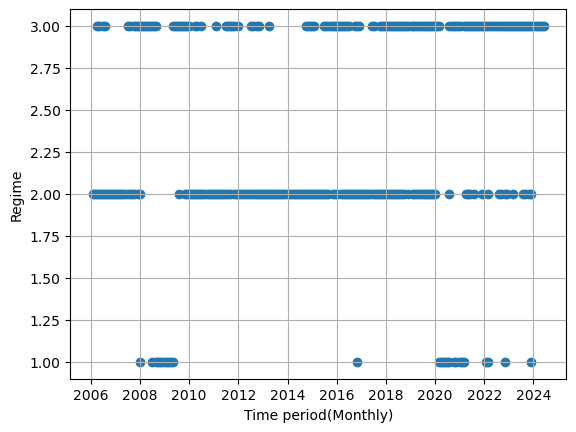

In [98]:
import warnings
warnings.filterwarnings("ignore")
Results = Herding_check.analyze_stock(3,'^GSPC')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

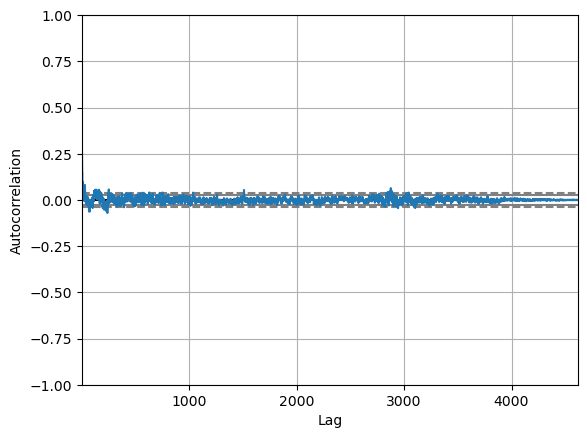

In [103]:
pd.plotting.autocorrelation_plot(Results.resid)  